In [2]:
import trimesh
import numpy as np
import open3d as o3d

# Load the OBJ file using trimesh
mesh = trimesh.load('SM_DmS_Pallet02.obj')

# Sample points from the mesh surface
num_points = 100000  # Adjust the number of points as needed
points, _ = trimesh.sample.sample_surface(mesh, num_points)

# Convert the points to an Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Save the point cloud to a PLY file
o3d.io.write_point_cloud('pallet_pointcloud.ply', point_cloud)

print("Point cloud saved to 'pallet_pointcloud.ply'")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Point cloud saved to 'pallet_pointcloud.ply'


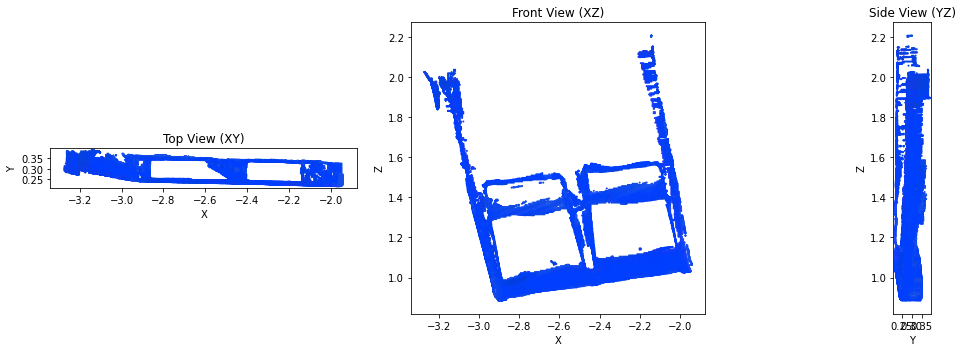

In [14]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt


# Load the PLY file
ply_file = "..\\ue4_dataset_generation\\dataset\\scene_object\\integrated.ply"
point_cloud = o3d.io.read_point_cloud(ply_file)

# Extract points and colors
points = np.asarray(point_cloud.points)
colors = np.asarray(point_cloud.colors)

# Define the blue color range
blue_color = np.array([0, 63/255, 1])  # Pure blue in normalized [0, 1] range
tolerance = 0.15  # Adjust the tolerance as needed

# Calculate the Euclidean distance from blue
distances = np.linalg.norm(colors - blue_color, axis=1)

# Filter points with color close to blue
threshold = tolerance
blue_indices = np.where(distances < threshold)[0]

# Create a new point cloud for blue points
blue_points = points[blue_indices]
blue_colors = colors[blue_indices]

# Function to plot point cloud from different views
def plot_point_cloud(blue_points, blue_colors, view, ax):
    if view == 'xy':
        ax.scatter(blue_points[:, 0], blue_points[:, 1], c=blue_colors, s=1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Top View (XY)')
    elif view == 'xz':
        ax.scatter(blue_points[:, 0], blue_points[:, 2], c=blue_colors, s=1)
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_title('Front View (XZ)')
    elif view == 'yz':
        ax.scatter(blue_points[:, 1], blue_points[:, 2], c=blue_colors, s=1)
        ax.set_xlabel('Y')
        ax.set_ylabel('Z')
        ax.set_title('Side View (YZ)')
    ax.set_aspect('equal', adjustable='box')

# Plot the point cloud from different views
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_point_cloud(blue_points, blue_colors, 'xy', axs[0])
plot_point_cloud(blue_points, blue_colors, 'xz', axs[1])
plot_point_cloud(blue_points, blue_colors, 'yz', axs[2])

plt.tight_layout()
plt.show()

In [18]:
pip install scikit-image

  Using cached scikit_image-0.23.2-cp310-cp310-win_amd64.whl (12.7 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
  Using cached imageio-2.34.1-py3-none-any.whl (313 kB)
  Using cached tifffile-2024.5.22-py3-none-any.whl (225 kB)
  Attempting uninstall: imageio
    Found existing installation: imageio 2.22.3
    Uninstalling imageio-2.22.3:
      Successfully uninstalled imageio-2.22.3
Note: you may need to restart the kernel to use updated packages.


Pallet Position: [-2.60432426  1.5288153 ]
Pallet Angle: 99.96235337884531
Pallet Length: 1.209637534292696
Pallet Width: 1.1458952340306419


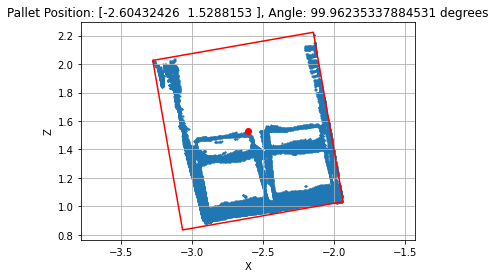

<Figure size 432x288 with 0 Axes>

In [53]:
# create 2d array of blue points in xz plane
blue_points_xz = blue_points[:, [0, 2]]
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def minimum_area_bounding_rectangle(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    min_area = np.inf
    best_rect = None
    best_angle = 0
    
    for i in range(len(hull_points)):
        p1 = hull_points[i]
        p2 = hull_points[(i + 1) % len(hull_points)]
        
        edge = p2 - p1
        angle = np.arctan2(edge[1], edge[0])
        
        # Rotate the points
        rotation_matrix = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])
        rotated_points = np.dot(points, rotation_matrix)
        
        # Find the bounding box
        min_x, min_y = np.min(rotated_points, axis=0)
        max_x, max_y = np.max(rotated_points, axis=0)
        
        area = (max_x - min_x) * (max_y - min_y)
        if area < min_area:
            min_area = area
            best_rect = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y]
            ])
            best_angle = angle
    
    # Rotate the best rectangle back to the original orientation
    rotation_matrix = np.array([
        [np.cos(-best_angle), -np.sin(-best_angle)],
        [np.sin(-best_angle), np.cos(-best_angle)]
    ])
    best_rect = np.dot(best_rect, rotation_matrix)
    
    # Calculate the center of the rectangle
    center = np.mean(best_rect, axis=0)

    # calculate the length and width of the rectangle
    length = np.linalg.norm(best_rect[0] - best_rect[1])
    width = np.linalg.norm(best_rect[1] - best_rect[2])
    
    return center, np.rad2deg(best_angle), best_rect, length, width

# Load the point cloud data
# Assuming points is a 2D numpy array of shape (N, 2) representing the xz-plane
points = blue_points_xz  # Replace with your actual point cloud data

center, angle, rect, length, width = minimum_area_bounding_rectangle(points)
print("Pallet Position:", center)
print("Pallet Angle:", angle)
print("Pallet Length:", length)
print("Pallet Width:", width)

# Plotting the results
plt.scatter(points[:, 0], points[:, 1], s=1)
plt.scatter(*center, color='red')
plt.title(f"Pallet Position: {center}, Angle: {angle} degrees")
plt.xlabel('X')
plt.ylabel('Z')
plt.grid(True)

# Plot the best fitting rectangle
rect = np.vstack([rect, rect[0]])  # Close the rectangle
plt.plot(rect[:, 0], rect[:, 1], 'r-')
# scale the axis equally
plt.axis('equal')
# white background
plt.figure(facecolor='white')
plt.show()


In [52]:
rect

array([[-1.93538146,  1.03223675],
       [-2.14465004,  2.22363493],
       [-3.27326705,  2.02539384],
       [-3.06399847,  0.83399566],
       [-1.93538146,  1.03223675]])

Pallet Position: [-2.60310544  0.29172047  1.52881908]
Pallet Angles: [-0.52556013  9.87959563 93.01496724]


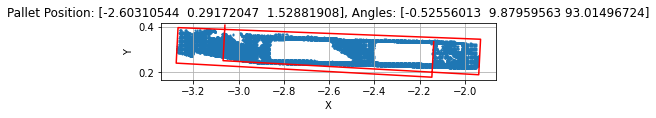

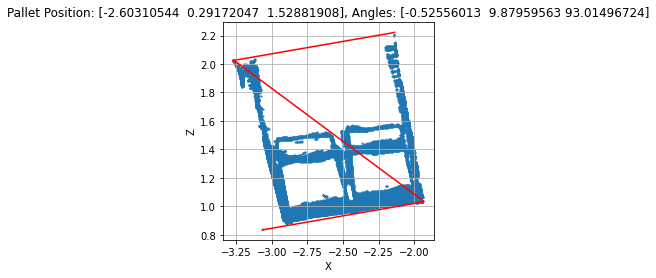

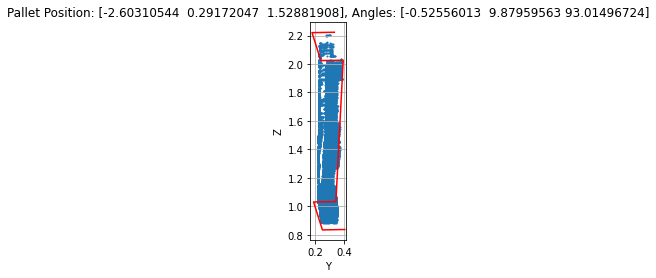

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import plotly.graph_objects as go

def minimum_volume_bounding_box(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    min_volume = np.inf
    best_box = None
    best_angles = (0, 0, 0)

    for simplex in hull.simplices:
        edge = points[simplex[1]] - points[simplex[0]]
        angle_x = np.arctan2(edge[1], edge[0])
        angle_y = np.arctan2(edge[2], edge[0])
        angle_z = np.arctan2(edge[2], edge[1])
        
        # Rotation matrices for each axis
        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(angle_x), -np.sin(angle_x)],
            [0, np.sin(angle_x), np.cos(angle_x)]
        ])
        Ry = np.array([
            [np.cos(angle_y), 0, np.sin(angle_y)],
            [0, 1, 0],
            [-np.sin(angle_y), 0, np.cos(angle_y)]
        ])
        Rz = np.array([
            [np.cos(angle_z), -np.sin(angle_z), 0],
            [np.sin(angle_z), np.cos(angle_z), 0],
            [0, 0, 1]
        ])

        R = np.dot(Rz, np.dot(Ry, Rx))
        rotated_points = np.dot(points, R.T)
        
        # Find the bounding box in the rotated space
        min_coords = np.min(rotated_points, axis=0)
        max_coords = np.max(rotated_points, axis=0)
        volume = np.prod(max_coords - min_coords)
        
        if volume < min_volume:
            min_volume = volume
            best_box = np.array([
                [min_coords[0], min_coords[1], min_coords[2]],
                [max_coords[0], min_coords[1], min_coords[2]],
                [max_coords[0], max_coords[1], min_coords[2]],
                [min_coords[0], max_coords[1], min_coords[2]],
                [min_coords[0], min_coords[1], max_coords[2]],
                [max_coords[0], min_coords[1], max_coords[2]],
                [max_coords[0], max_coords[1], max_coords[2]],
                [min_coords[0], max_coords[1], max_coords[2]]
            ])
            best_angles = (angle_x, angle_y, angle_z)
    
    # Rotate the best box back to the original orientation
    Rx_inv = np.array([
        [1, 0, 0],
        [0, np.cos(-best_angles[0]), -np.sin(-best_angles[0])],
        [0, np.sin(-best_angles[0]), np.cos(-best_angles[0])]
    ])
    Ry_inv = np.array([
        [np.cos(-best_angles[1]), 0, np.sin(-best_angles[1])],
        [0, 1, 0],
        [-np.sin(-best_angles[1]), 0, np.cos(-best_angles[1])]
    ])
    Rz_inv = np.array([
        [np.cos(-best_angles[2]), -np.sin(-best_angles[2]), 0],
        [np.sin(-best_angles[2]), np.cos(-best_angles[2]), 0],
        [0, 0, 1]
    ])
    
    R_inv = np.dot(Rx_inv, np.dot(Ry_inv, Rz_inv))
    best_box = np.dot(best_box, R_inv.T)
    
    # Calculate the center of the box
    center = np.mean(best_box, axis=0)
    
    return center, np.rad2deg(best_angles), best_box

# Load the point cloud data
points = blue_points  # Replace with your actual point cloud data

center, angles, box = minimum_volume_bounding_box(points)
print("Pallet Position:", center)
print("Pallet Angles:", angles)

# Define the plotting function for each plane
def plot_plane(points, box, plane='xy'):
    plt.figure()
    if plane == 'xy':
        plt.scatter(points[:, 0], points[:, 1], s=1)
        plt.plot(box[:, 0], box[:, 1], 'r-')
        plt.xlabel('X')
        plt.ylabel('Y')
    elif plane == 'xz':
        plt.scatter(points[:, 0], points[:, 2], s=1)
        plt.plot(box[:, 0], box[:, 2], 'r-')
        plt.xlabel('X')
        plt.ylabel('Z')
    elif plane == 'yz':
        plt.scatter(points[:, 1], points[:, 2], s=1)
        plt.plot(box[:, 1], box[:, 2], 'r-')
        plt.xlabel('Y')
        plt.ylabel('Z')
    plt.title(f'Pallet Position: {center}, Angles: {angles}')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Plot in XY plane
plot_plane(points, box, plane='xy')

# Plot in XZ plane
plot_plane(points, box, plane='xz')

# Plot in YZ plane
plot_plane(points, box, plane='yz')


# Interactive 3D plot using plotly
fig = go.Figure(data=[
    go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2], 
        mode='markers', marker=dict(size=2)
    ),
    go.Scatter3d(
        x=box[[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3], 0],
        y=box[[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3], 1],
        z=box[[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3], 2],
        mode='lines', line=dict(color='red', width=2)
    )
])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', nticks=10, range=[np.min(points[:, 0]), np.max(points[:, 0])]),
        yaxis=dict(title='Y', nticks=10, range=[np.min(points[:, 1]), np.max(points[:, 1])]),
        zaxis=dict(title='Z', nticks=10, range=[np.min(points[:, 2]), np.max(points[:, 2])]),
        aspectmode='data'
    ),
    title=f"Pallet Position: {center}, Angles: {angles}"
)

fig.show()


In [47]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

def minimum_volume_bounding_box(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    min_volume = np.inf
    best_box = None
    best_angles = (0, 0, 0)

    for simplex in hull.simplices:
        edge = points[simplex[1]] - points[simplex[0]]
        angle_x = np.arctan2(edge[1], edge[0])
        angle_y = np.arctan2(edge[2], edge[0])
        angle_z = np.arctan2(edge[2], edge[1])
        
        # Rotation matrices for each axis
        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(angle_x), -np.sin(angle_x)],
            [0, np.sin(angle_x), np.cos(angle_x)]
        ])
        Ry = np.array([
            [np.cos(angle_y), 0, np.sin(angle_y)],
            [0, 1, 0],
            [-np.sin(angle_y), 0, np.cos(angle_y)]
        ])
        Rz = np.array([
            [np.cos(angle_z), -np.sin(angle_z), 0],
            [np.sin(angle_z), np.cos(angle_z), 0],
            [0, 0, 1]
        ])

        R = np.dot(Rz, np.dot(Ry, Rx))
        rotated_points = np.dot(points, R.T)
        
        # Find the bounding box in the rotated space
        min_coords = np.min(rotated_points, axis=0)
        max_coords = np.max(rotated_points, axis=0)
        volume = np.prod(max_coords - min_coords)
        
        if volume < min_volume:
            min_volume = volume
            best_box = np.array([
                [min_coords[0], min_coords[1], min_coords[2]],
                [max_coords[0], min_coords[1], min_coords[2]],
                [max_coords[0], max_coords[1], min_coords[2]],
                [min_coords[0], max_coords[1], min_coords[2]],
                [min_coords[0], min_coords[1], max_coords[2]],
                [max_coords[0], min_coords[1], max_coords[2]],
                [max_coords[0], max_coords[1], max_coords[2]],
                [min_coords[0], max_coords[1], max_coords[2]]
            ])
            best_angles = (angle_x, angle_y, angle_z)
    
    # Rotate the best box back to the original orientation
    Rx_inv = np.array([
        [1, 0, 0],
        [0, np.cos(-best_angles[0]), -np.sin(-best_angles[0])],
        [0, np.sin(-best_angles[0]), np.cos(-best_angles[0])]
    ])
    Ry_inv = np.array([
        [np.cos(-best_angles[1]), 0, np.sin(-best_angles[1])],
        [0, 1, 0],
        [-np.sin(-best_angles[1]), 0, np.cos(-best_angles[1])]
    ])
    Rz_inv = np.array([
        [np.cos(-best_angles[2]), -np.sin(-best_angles[2]), 0],
        [np.sin(-best_angles[2]), np.cos(-best_angles[2]), 0],
        [0, 0, 1]
    ])
    
    R_inv = np.dot(Rx_inv, np.dot(Ry_inv, Rz_inv))
    best_box = np.dot(best_box, R_inv.T)
    
    # Calculate the center of the box
    center = np.mean(best_box, axis=0)
    
    return center, np.rad2deg(best_angles), best_box

# Load the point cloud data
points =blue_points  # Replace with your actual point cloud data

center, angles, box = minimum_volume_bounding_box(points)
print("Pallet Position:", center)
print("Pallet Angles:", angles)

# Define the vertices for the 3D bounding box
x = box[:, 0]
y = box[:, 1]
z = box[:, 2]

# Define the faces of the bounding box
faces = np.array([
    [0, 1, 2, 3],  # Bottom face
    [4, 5, 6, 7],  # Top face
    [0, 1, 5, 4],  # Front face
    [2, 3, 7, 6],  # Back face
    [1, 2, 6, 5],  # Right face
    [4, 7, 3, 0]   # Left face
])

fig = go.Figure(data=[
    go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2], 
        mode='markers', marker=dict(size=2)
    ),
    go.Mesh3d(
        x=x, y=y, z=z,
        i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
        opacity=0.5,
        color='red'
    )
])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', nticks=10, range=[np.min(points[:, 0]), np.max(points[:, 0])]),
        yaxis=dict(title='Y', nticks=10, range=[np.min(points[:, 1]), np.max(points[:, 1])]),
        zaxis=dict(title='Z', nticks=10, range=[np.min(points[:, 2]), np.max(points[:, 2])]),
        aspectmode='data'
    ),
    title=f"Pallet Position: {center}, Angles: {angles}"
)

fig.show()



Pallet Position: [-2.60310544  0.29172047  1.52881908]
Pallet Angles: [-0.52556013  9.87959563 93.01496724]


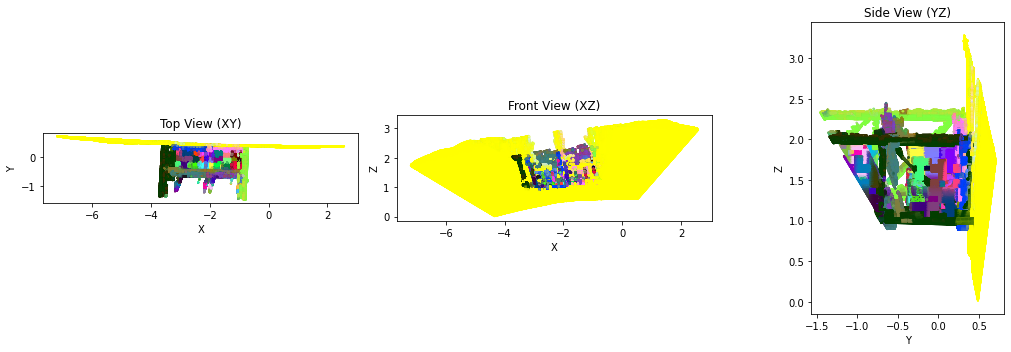

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_point_cloud(points, colors, 'xy', axs[0])
plot_point_cloud(points, colors, 'xz', axs[1])
plot_point_cloud(points, colors, 'yz', axs[2])

plt.tight_layout()
plt.show()

In [ ]:
100x120x12